In [1]:
import torch.nn as nn
import torch
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
import torchaudio.transforms as AT
import os
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import librosa.display, librosa
torch.manual_seed(1)

/Users/dlwlrma71/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


# [High-level Implementation of Wide & Narrowband Mel-Spectrogram]

### Use 16kHz signals 

In [26]:
filedir = './myvoice16k.wav'
y, sr = librosa.load(filedir, sr = 16000)

## Step1: Spectrogram

#### Narrowband: 20ms window, 5ms shift
window length: 20x16 = 320 -> N_point FFT : 512

shift : 5x16 = 80
#### Wideband: 4ms window, 1ms shift
window length: 4x16 = 64 -> N_point FFT: 64

shift: 1x16 = 16

In [27]:
N_windowlen = 320
N_NFFT = 512
N_shift = 80

W_windowlen = 64
W_NFFT = 64
W_shift = 16

In [28]:
def Spectrogram(signal, N_FFT, window_len, shift, sample_rate):
    
    S = librosa.stft(signal, n_fft =N_FFT, 
                        hop_length = shift, win_length = window_len)
    print("STFT shape: ", S.shape)
    S_abs = np.abs(S)
    S_db = librosa.amplitude_to_db(S_abs, ref = np.max)
    plt.figure(figsize = (10,5))
    librosa.display.specshow(S_db, sr = sample_rate, x_axis = 'time', y_axis = 'linear', hop_length = shift)
    
    plt.xlabel('time')
    plt.ylabel('frequency')
    plt.colorbar(format = '%+2.0f dB')
    plt.title('spectrogram')
    
    return S_db

STFT shape:  (257, 4233)


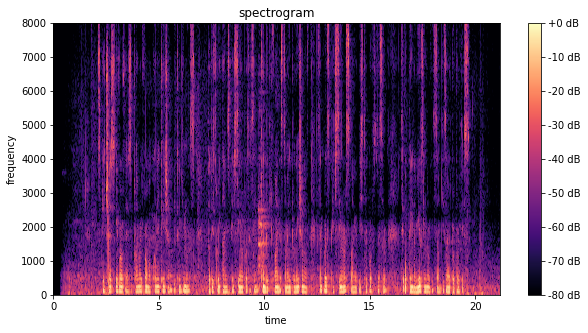

In [29]:
'''Narrowband'''
N_spectrogram = Spectrogram(y, N_NFFT, N_windowlen,N_shift, sr)

STFT shape:  (33, 21163)


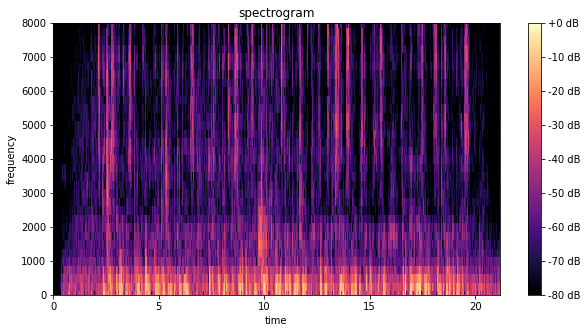

In [30]:
'''Wideband'''
W_spectrogram = Spectrogram(y, W_NFFT, W_windowlen, W_shift, sr)

## Step2: Log Mel-spectrum

#### Window length: 20ms, Shift: 10ms

(window length: 320 sample, shift: 160 sample)

In [31]:
def Mel_Spectrogram(wav_file, N_FFT, window_len, shift, sample_rate, n_mels):
    
    Mel_S = librosa.feature.melspectrogram(wav_file, n_fft =N_FFT, 
                        hop_length = shift, win_length = window_len, n_mels = n_mels)
    print("Mel_S shape: ", Mel_S.shape)
    Mel_S_db = librosa.power_to_db(Mel_S, ref = np.max) #Compute dB relative to peak power
    plt.figure(figsize = (10,5))
    librosa.display.specshow(Mel_S_db, sr = sample_rate, hop_length = shift, x_axis = 'time', y_axis = 'mel')
    plt.xlabel('time')
    plt.ylabel('frequency')
    plt.colorbar(format = '%+2.0f dB')
    plt.title('Mel_spectrogram')
    
    return Mel_S

Mel_S shape:  (128, 2117)


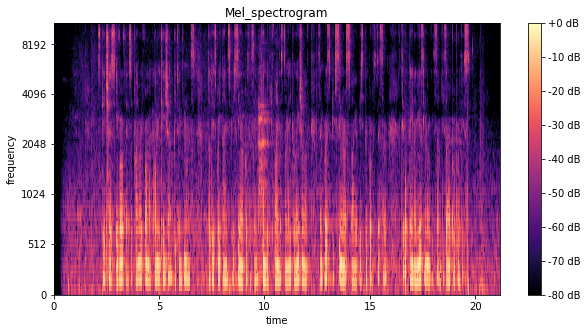

In [32]:
N_FFT = 512
window_len = 320
shift = 160
n_mels = 128
Mel_S = Mel_Spectrogram(y, N_FFT, window_len, shift, sr, n_mels)

# [Low-level implementation of Mel-spectrogram and MFCCs]

## Step 0: Overview



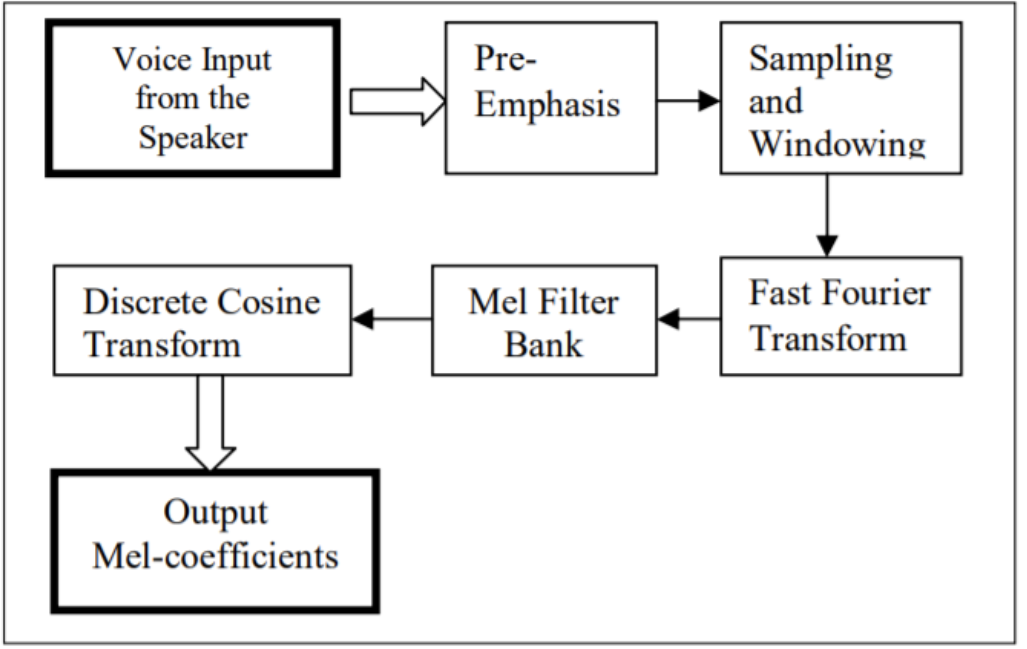

## Step 1: Preemphasis

### 고주파 성분의 에너지를 조금 올려주어 고른 에너지 분포를 갖게 한다.

### Improve the Signal-to-Noise Ratio (SNR)

### y(t)=x(t)−αx(t−1) 
#### Preemphasis coefficient (α) = 0.95 or 0.97

In [33]:
def preemphasis(signal,a):
    return np.append(signal[0], signal[1:]-a*signal[:-1])

In [34]:
#앞서 librosa로 추출한 signal y를 preemphasis
y = preemphasis(y,0.97)

## Step 2: Framing

### Window length: 20ms (320 sample), Shift: 10ms (160 sample)

최종적으로 신호를 N개의 프레임과 그에 각각 대응되는 320개의 샘플로 나눈다.

Framing 함수는 전체 신호에 대해 160의 간격으로 각각 320개의 인덱스 값과 신호 값을 담고 있는 두 2차원 행렬을 반환한다.

In [35]:
def Framing(signal, frame_length, frame_step):
    f_len, f_step = frame_length, frame_step
    s_len = len(signal)
    num_f = int(np.ceil(float(np.abs(s_len-f_len))/f_step))
    pad_signal_length = num_f*f_step+f_len
    z = np.zeros((pad_signal_length-s_len))
    pad_signal = np.append(signal,z)
    print('#of frames(N):',num_f)

    indices = np.tile(np.arange(0, f_len), (num_f, 1)) + \
          np.tile(np.arange(0, num_f * f_step, f_step), (f_len, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    print('indices shape:',indices.shape,'\tframes shape: ', frames.shape)
    return indices, frames

In [36]:
y_indices, y_frames = Framing(y,320,160)
print('\n-----indices-----\n',y_indices[:2], '\n\n-----frames-----') # 첫 번째, 두 번째 프레임을 인덱스로 표현(각각 320 sample)
print(y_frames[1000:1002], '\n')   #1001, 1002번째 프레임에 담겨 있는 정보(각각 320 sample)

#of frames(N): 2115
indices shape: (2115, 320) 	frames shape:  (2115, 320)

-----indices-----
 [[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
  126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
  144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
  162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
  180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
  198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
  216 217 218 219

## Step 3: Windowing

### Hamming window 
### w[n]=0.54−0.46cos(2πn/(N−1))

Hammin window 관련 추가 설명: https://ratsgo.github.io/speechbook/docs/neuralfe/sincnet#windowing--hamming-window

In [37]:
def ham_windowing(frames, frame_length):
    frames *= np.array([0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1)) for n in range(frame_length)])
    return frames

In [38]:
ham_frames = ham_windowing(y_frames, 320)
ham_frames.shape

(2115, 320)

## Step 4: Fourier Transform

### Use Numpy rfft

why rfft? : compute only the non-negative frequency terms
(real_fft)

In [39]:
def framesFFT(frames, N_FFT):
    return np.fft.rfft(frames, N_FFT)

In [40]:
N_FFT = 512
dft_frames = framesFFT(ham_frames, N_FFT)
dft_frames.shape  
#return shape : (num_frames, N_FFT/2+1)

(2115, 257)

## Step 5: Power Spectrum

### Power= $|X[k]|^2 \over N$


In [41]:
def powerspectrum(dft_frames, N_FFT):
    p_S = ((np.absolute(dft_frames))**2.0)/N_FFT
    return p_S

In [42]:
P_spectrum = powerspectrum(dft_frames, N_FFT)
P_spectrum.shape

(2115, 257)

## Step 6: Log-Mel Spectrum with Mel Scale Filter Banks

### Mel scale: Non-linear transformation of the frequency scale

각 프레임별로 저주파수 영역대를 상대적으로 강조시킨다. 수식은 아래와 같다.

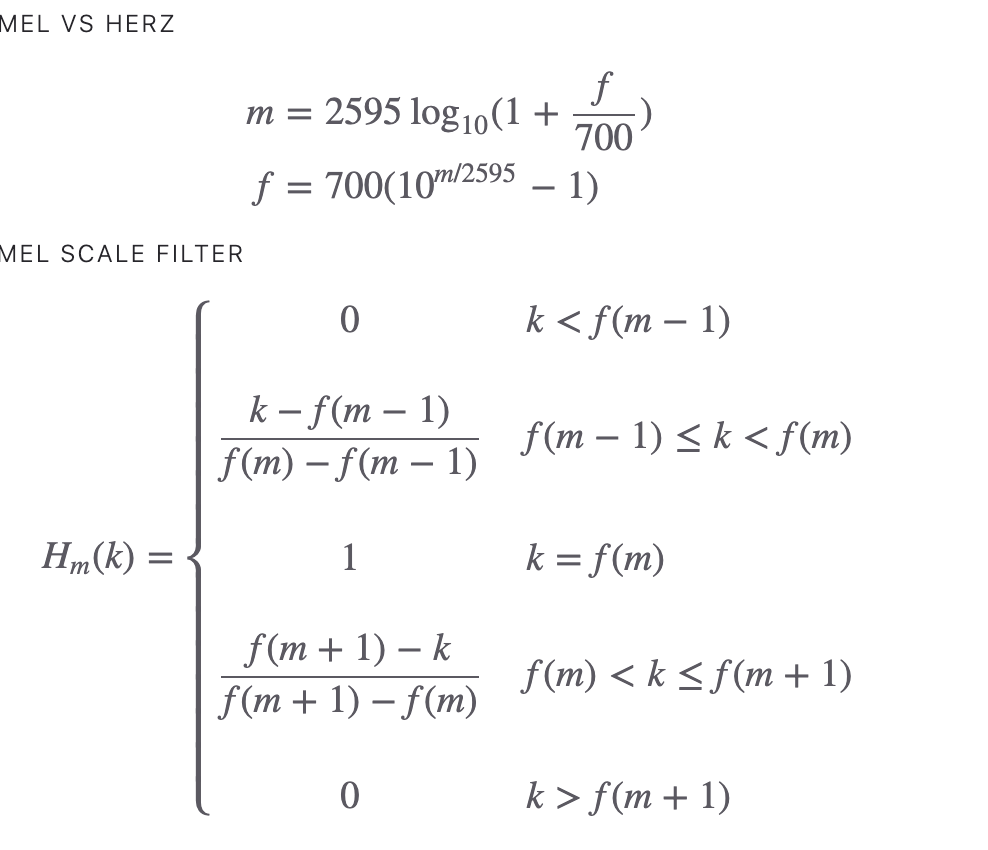

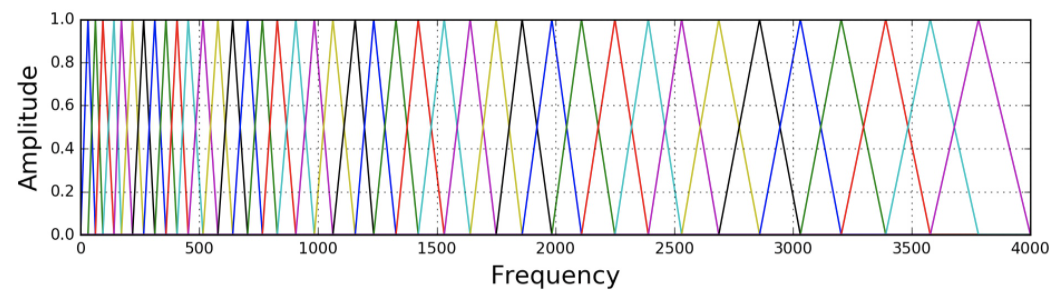

In [43]:
def filterbanks(n_filters,sample_rate, N_FFT):
    min_mel = 0
    max_mel = (2595*np.log10(1+0.5*sample_rate/700)) #max Hz to mel
    mel_points = np.linspace(min_mel,max_mel, n_filters+2)
    hz_points = (700*(10**(mel_points/2595)-1))
    bin = np.floor((N_FFT + 1) * hz_points / sample_rate)
    
    fbank = np.zeros((n_filters, int(np.floor(N_FFT/2+1))))
    for m in range(1, n_filters + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
    return fbank

In [44]:
def LogMelSpec(power_spectrum, n_filters, sample_rate, N_FFT):
    
    Mel_filter = filterbanks(n_filters, sample_rate, N_FFT)
    print('Mel_filter banks shape: ', Mel_filter.shape)
    Mel_Spec = np.dot(power_spectrum, Mel_filter.T)
    Log_Mel_Spec = 20*np.log(Mel_Spec+1e-12)
    return Log_Mel_Spec

In [45]:
n_filters = 40

Logmel_S = LogMelSpec(P_spectrum, n_filters, sr, N_FFT)
print('\nLogmel Spectrum shape: ',Logmel_S.shape)
#librosa.display.specshow(Logmel_S.T)
#plt.colorbar(format = '%+2.0f dB')

Mel_filter banks shape:  (40, 257)

Logmel Spectrum shape:  (2115, 40)


## Step 7: MFCC 

### Use DCT to yield a compressed representation

MFCC order = 12   (remain only cepstral coefficients 2~13)

In [46]:
from scipy.fftpack import dct
num_ceps = 12
mfcc = dct(Logmel_S, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [47]:
print(mfcc.shape)

(2115, 12)


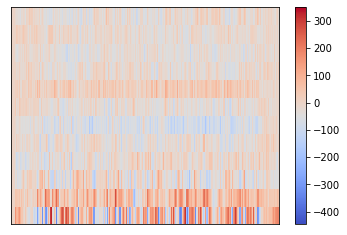

In [48]:
librosa.display.specshow(mfcc.T)
plt.colorbar()